## 基礎建設

In [170]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [171]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-26 15:47:04--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.2’

All_Beauty.csv.2    100%[===================>]  14.78M  24.5MB/s    in 0.6s    

2021-12-26 15:47:05 (24.5 MB/s) - ‘All_Beauty.csv.2’ saved [15499476/15499476]

--2021-12-26 15:47:05--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.2’

meta_All_Beauty.jso 100%[===================>]   9.85M  18.6MB/s    in 0.5s   

In [172]:
#商品的基本資訊 metadata,購買商品的紀錄 ratings
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

## 資料整理

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [174]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [201]:
#no_ratings = ratings[['reviewerID','asin']].groupby("reviewerID").count().sort_values(by=['asin'], ascending=False).reset_index()

In [203]:
# 商品資訊-只留下要求的欄位
purchase_df = metadata[['asin', 'brand', 'title', 'price', 'rank']]

#商品資訊-買什麼種類
purchase_df['categories'] = purchase_df['rank'].str.split(expand = True).loc[:, 2:5].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

# 取出字串前段數字,取代掉千分位
purchase_df['rank'] = purchase_df['rank'].str.split(expand = True)[0].str.replace(',', '')
#轉換型別
purchase_df['rank'] = pd.to_numeric(purchase_df['rank'])

In [204]:
#商品資訊-對應類別
purchase_category_df = purchase_df[['asin','categories']].drop_duplicates(subset=['asin','categories'])

In [182]:
ratings = pd.merge(ratings, purchase_category_df, on="asin", how="left").fillna("unknown")

# 資料描繪

In [184]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [185]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

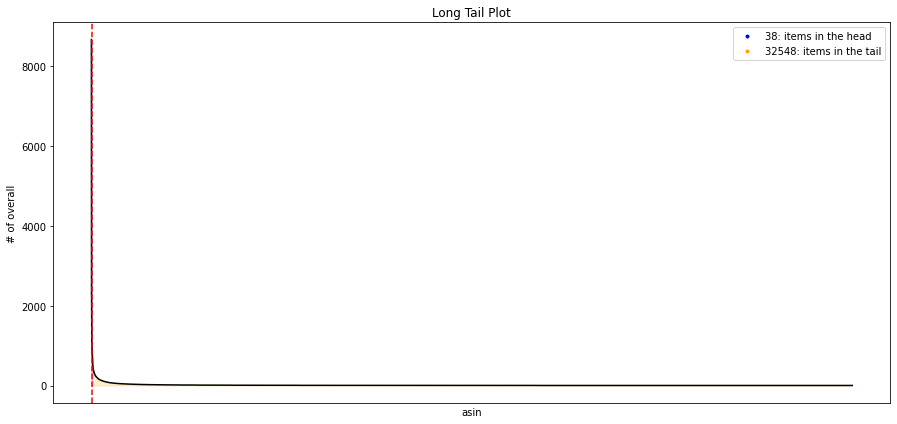

In [186]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,7))
long_tail_plot(df= ratings,
                         item_id_column='asin',
                         interaction_type='overall',
                         percentage=0.2,
                         x_labels=False)

In [187]:
 def longtail_head_asin(df, item_id_column, percentage=None):
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    if percentage != None:
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = list(head['asin'].unique())
        #items_in_tail = list(tail['asin'].unique())
    return items_in_head

In [188]:
head_asin = longtail_head_asin(df= ratings,
                         item_id_column='asin',
                         percentage=0.2)

## 資料切分

In [189]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]

In [190]:
#group by 用戶ID {'asin': ['B017JBTB98'], 'reviewerID': 'ACCY5NWUNEC87'}
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')

#換格式 {'A12M4U7WK4ALCR': ['B01DKQAXC0']}
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
#所有用戶 'ATR9J7TYR1KVL'
users = list(ratings_testings_by_user.keys())

In [191]:
user_category = ratings_trainings[ratings_trainings['categories'] != "unknown"].groupby(by=['reviewerID','categories']).size().reset_index()
user_category.columns = ["user", "categories","volumn"]
grouped_df = user_category.groupby("user")
user_category_max = grouped_df.max()
user_category_max = user_category_max.reset_index()

In [192]:
#pd.merge(user_category_max[['user', 'categories']],----,on='categories',how='outer')

SyntaxError: ignored

## 產生推薦

In [198]:
# 推薦最近三個月內銷量排行前十名的商品

def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}

    training_data = training_data[(training_data['DATE'] >= '2018-06-01') \
                                  & (training_data['DATE'] < '2018-09-01')]

    within3month_top10 = training_data.groupby('asin').count().sort_values('overall',ascending=False).head(10).index.tolist()

    recommendations = {user: within3month_top10 for user in users}
    return recommendations

In [199]:
ratings_by_user = recommender(ratings_trainings, users)

## 結果評估

In [200]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.13389830508474576

# 測試

In [193]:
from random import sample

In [ ]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}

    ratings_trainings = training_data
    #排除熱銷商品
    new_list = []
    for i in set(ratings_trainings['asin']):
      if i not in head_asin:
        new_list.append(i)
    #推薦使用者最常使用的類別asin
    user_category_max


    recommendations = {user: sample(new_list,k) for user in users}
    return recommendations